We will import the libraries needed throughout this notebook.

In [711]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

We will read in pre-classified disaster tweets and the post-classified disaster tweets.


In [712]:
combined_pre = pd.read_csv('./assets/combined_pre_classed.csv', index_col= 0)
combined_post = pd.read_csv('./assets/combined_post_classed.csv', index_col=0)

These are the additional stopwords we came up with to add to the original stopwords to fish out for more important words that may give us better insight on the organic message of the twitter users when it comes to disasters or not. Bulk of the new stop words added the specific names of the natural disasters that we used for this project as well as terms closely associated with mass-shootings. In our earthquake data, many of the tweets that were scaped were during a time of a mass-shooting that recently took place in Thousand Oaks at a bar. We made sure to remove such words to minimize the impact it can have in our pre-processing.

Once we formed our new stopwords, we pickled it so that it can be saved and called upon in our future notebooks. More information on pickling can be found [here](https://pythontips.com/2013/08/02/what-is-pickle-in-python/).


In [713]:
add_stop = ['http', 'www', 'org', 'reddit', 'youtube', 'facebook', 'amp', 
            'deleted', 'removed', 'rt', 'twitter', 'com', 'net', 'carr', 'irma', 'harvey',
            'maria', 'carrfire', 'camp', 'campfire', 'woolsey', 
            'woolseyfire', 'prague', 'north', 'northbay', 'news',
            'hurricaneirma', 'hurricaneharvey', 'hurricanemaria',
            'headline', 'breaking', 'shooting', 'guns', 'gun', 
            'shoot', 'bullets', 'bullet', 'shootings', 
            'clip', 'bar', 'college','student','students', 
            'magazine', 'ammo', 'ammunition','shootings', 
            'rampage', 'gunman', 'stabbing', 'slayings', 'shooter', 
            'fatally', 'killings', 'killing', 'shot', 'unarmed', 
            'massacre', 'slaying', 'incident', 'stabbings','altercation', 
            'shooters', 'murder', 'shoot', 'carjacking', 'gunned', 'murders', 
            'firing', 'newtown', 'scuffle', 'gunmen', 'florida', 'keys', 'key', 
            'school', 'ian', 'david','texas', 'miami', 'california', 'harvey', 'thousandoaks',
           'assault','houston', 'ventura', 'san','cudjoe', 'oaks', 'en', 'de', 'la', 
            'el', 'tiroteo', 'th','massshooting','californiashooting']

In [714]:
add_stop_set = set(add_stop)
add_stop_list = list(add_stop_set)

stopwords = nltk.corpus.stopwords.words('english')

stopwords.extend(add_stop_list)

In [715]:
len(stopwords)

273

In [716]:
# Pickling the updated stopwords
with open('./assets/stopwords.pkl', 'wb') as f:
    pickle.dump(stopwords, f)

We combined the two separate dataframes into one. Together the rows almost equal a 100,000 tweets.

In [717]:
combined_df = pd.concat([combined_pre, 
                        combined_post], 
                       ignore_index=True)

In [718]:
combined_df.shape

(98550, 2)

About 77% of the data are classified as being non-disaster related; whereas, 22% of them are. As we can see, the baseline accuracy is 77.4%. Our future models has to have better score than just being able to pick the majority class as prediction.

In [719]:
combined_df.disaster.value_counts(normalize=True)

0    0.774419
1    0.225581
Name: disaster, dtype: float64

In [720]:
combined_df.to_csv('../project_4/assets/combined_df.csv')

We will implement the Term Frequency–Inverse Document Frequency (TFIDF) tool to have the words recored as integer counts in order to be used on a the Logistic Regression model. We will also split our data into 'X' and 'y'. The X is an object that consists of the predictor column, in this case the text (tweets). The y will contain the binary classifier column, whether or not the tweets belongs to a disaster class or non-disaster class.

In [669]:
y = combined_df['disaster']

# Set X as text column.
X = combined_df['text']

We will randomly split the data into training and test sets. This is done so we can train our model on the training set and then evaluate the performance of the model on unseen new data (the validation set).

In [670]:
# Train/test split our data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 42, 
                                                    stratify=y)

In [671]:
tfidf = TfidfVectorizer(stop_words = stopwords, 
                        max_df=0.95, 
                        min_df=5, max_features=10_000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

We will do an initial attempt to classify the tweets according to its' corresponding class by utilizing the TFIDF tool to the logistic regression model.

The logistic model will return a predicted score between 0 and 1 that indicates the accuracy percentage of whether the model correctly predicted a given tweet as being from the disaster class or non-disaster class.

In [672]:
from sklearn.linear_model import LogisticRegression

In [673]:
logreg = LogisticRegression()
model = logreg.fit(X_train_tfidf,y_train)

/Users/jameslee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The naive Logistic Regression model gives us a test score of 95.1%. This is a 18% improvement over the baseline accuracy score.

In [674]:
model.score(X_train_tfidf, y_train)

0.9591940276871783

In [675]:
model.score(X_test_tfidf, y_test)

0.9512599357348216

----

## PCA: 
With 10,000 max features; we have a significant size of columns. There are various ways we can solve for this. One option is to obviously drop some of the words. However, not only will this be extremey time consuming to figure out which ones to drop; it is also a potential loss of information. As a result, we decided to try Principle Component Analysis (PCA).

PCA is a form of feature extraction. This allows us to take our existing features and combine them together in a particular way. We can then drop some of these "new" variables, but the variables we keep are still a combination of the old variables.

In [676]:
X_train_df_tfidf = pd.SparseDataFrame(X_train_tfidf,
                             columns=tfidf.get_feature_names())

In [677]:
X_train_df_tfidf.shape

(68985, 10000)

In [678]:
X_test_df_tfidf = pd.SparseDataFrame(X_test_tfidf,
                                    columns=tfidf.get_feature_names())

In [679]:
X_test_df_tfidf.shape

(29565, 10000)

In [680]:
X_train_df_tfidf.head()

,__,____,_hustle_junky,aa,aaa,aan,aaron,ab,abandoned,abatido,...,zr,zs,zswaggers,zswagtour,zu,zv,zw,zx,zy,zz
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [681]:
X_train_df_tfidf.fillna(0, inplace=True)

In [682]:
X_test_df_tfidf.fillna(0, inplace=True)

In [683]:
X_train_df_tfidf.sum().sort_values(ascending = False).head(20)

pic          1918.173348
hurricane    1852.736735
thousand     1376.447568
west          713.900895
people        711.835950
storm         648.255764
landfall      583.279153
via           551.470766
like          529.074651
mass          523.550272
love          492.007504
category      482.597259
live          472.964642
get           460.626337
day           457.450875
residents     455.620306
one           435.520438
go            435.373772
today         432.962694
makes         424.341345
dtype: float64

In [686]:
X_train_array = np.asarray(X_train_df_tfidf)

X_test_array = np.asarray(X_test_df_tfidf)

### PCA: Breakdown

- We are going to look at how all of these variables relate to one another and summarize these relationships.
- Then, by looking at these summaries we can see which combinations of our variables are most important.
- We can also score how important each combination is.

There are two things we must do prior to applying the PCA. 
* train/test split
* Standardize our data

Forunately, we made sure to do this above. We did the train-test split when we ran our naive Logistic Regression model and the TFIDF tool also automatically scaled our data.

In [690]:
# Import PCA.
from sklearn.decomposition import PCA

n_component will originally default to the minimum number of either the samples or features in the data, in this case 10,000 features. Due to the time and computation power, we decided to try this out with a hundred components.

In [705]:
# Instantiate PCA.
pca = PCA(n_components=100)

In [706]:
pd.DataFrame(X_train_array).shape

(68985, 10000)

In [707]:
# Fit PCA on the training data.
Z_train = pca.fit_transform(X_train_array)

In [708]:
pd.DataFrame(Z_train).describe()

# column 0 is the first principal component

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,...,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04,6.898500e+04
mean,3.675698e-18,1.472150e-17,-2.461555e-18,7.634443e-19,-2.516751e-18,4.859187e-18,3.289349e-18,-1.547438e-17,6.850680e-18,-3.668556e-18,...,9.552106e-19,-1.686367e-18,6.345288e-18,-8.099701e-18,-1.886945e-17,-1.422280e-18,4.821669e-18,-5.554233e-18,-4.106933e-18,-4.124007e-19
std,9.409049e-02,8.154704e-02,7.321089e-02,6.728463e-02,6.351922e-02,5.716681e-02,5.622178e-02,5.433904e-02,5.355162e-02,5.233427e-02,...,3.286227e-02,3.274252e-02,3.259145e-02,3.233416e-02,3.225325e-02,3.210731e-02,3.202864e-02,3.184728e-02,3.175393e-02,3.170082e-02
min,-2.514687e-01,-8.212807e-02,-3.046646e-01,-3.291062e-01,-3.378034e-01,-5.395169e-01,-2.951732e-01,-5.600495e-01,-3.938453e-01,-3.535226e-01,...,-2.942394e-01,-3.209860e-01,-2.890211e-01,-2.634059e-01,-2.511594e-01,-2.405896e-01,-2.370746e-01,-2.421881e-01,-2.578453e-01,-3.179619e-01
25%,-3.946221e-02,-4.238490e-02,-2.120500e-02,-1.417025e-02,-8.655793e-03,-4.859237e-03,-1.956917e-02,-3.499857e-03,-1.229949e-02,-1.287198e-02,...,-1.079684e-02,-1.068850e-02,-1.042930e-02,-1.101918e-02,-1.122808e-02,-1.222785e-02,-1.239116e-02,-1.091756e-02,-1.289615e-02,-1.080332e-02
50%,-3.035316e-02,-3.553445e-02,-7.394220e-03,-5.813809e-03,5.819240e-03,1.133357e-03,-7.020302e-03,4.946493e-04,2.971891e-03,-4.523501e-03,...,-8.651670e-07,-6.798903e-04,-1.335951e-03,9.403276e-04,6.174261e-04,-2.739829e-03,1.335140e-04,3.974415e-04,-1.273664e-03,-2.677264e-04
75%,2.546312e-03,1.330170e-02,-2.258000e-03,1.049037e-03,1.045192e-02,8.789232e-03,1.795350e-03,6.636206e-03,1.175499e-02,4.687187e-03,...,1.135129e-02,1.081671e-02,9.207867e-03,1.041979e-02,1.015300e-02,9.330155e-03,1.101568e-02,1.163077e-02,1.018766e-02,9.981834e-03
max,7.512354e-01,7.018856e-01,8.197603e-01,7.534351e-01,7.353519e-01,5.618245e-01,5.576236e-01,6.196925e-01,7.411997e-01,7.647094e-01,...,3.029199e-01,4.756606e-01,4.567117e-01,3.358963e-01,3.373259e-01,2.945932e-01,2.672481e-01,2.889947e-01,3.320830e-01,3.322953e-01


Since our primary goal with PCA was to do dimensionality reduction, removing some of the features.
We decided to measure how important each principal component is using the eigenvalue (score of importance), and as a result sklearn displays the first column as the most important.

In order to find out up to which features to keep and what to remove, we utilized the cumulative of explained variance.
The explained variance tells us how much information (variance) is captured by each principal component. Clearly from the two plots shown below, these are extremely low amounts of variance that are explained by our principal components. With a 100 components, we only get a total of almost 20% variance explained. It may not be worthwhile to continue the rest of the project using the PCA model.

In [695]:
var_exp = pca.explained_variance_ratio_
print(f'Explained variance: {np.round(var_exp,3)}')

cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance: {np.round(cum_var_exp,3)}')

Explained variance: [0.009 0.007 0.005 0.005 0.004 0.003 0.003 0.003 0.003 0.003 0.003 0.003
 0.003 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001]
Cumulative explained variance: [0.009 0.016 0.021 0.026 0.03  0.033 0.036 0.039 0.042 0.045 0.048 0.05
 0.053 0.056 0.058 0.061 0.063 0.066 0.068 0.07  0.072 0.074 0.076 0.079
 0.081 0.082 0.084 0.086 0.088 0.09  0.092 0.094 0.096 0.097 0.099 0.101
 0.103 0.104 0.106 0.108 0.109 0.111 0.113 0.114 0.116 0.118 0.119 0.121
 0.122 0.124 0.125 0.127 0.128 0.13  0.131 0.133

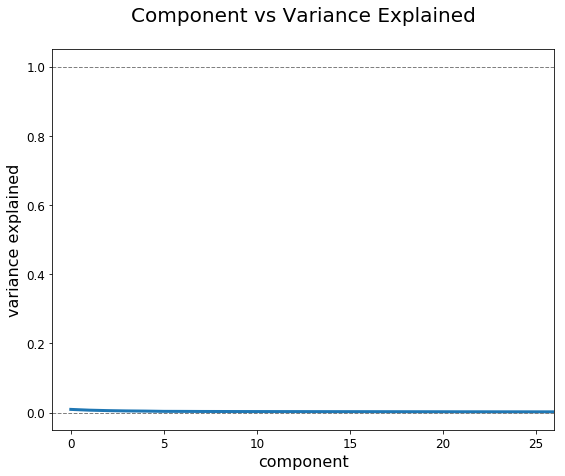

In [696]:
plt.figure(figsize=(9,7))

# Plot the explained variance
component_number = range(len(var_exp))
plt.plot(component_number, var_exp, lw=3)

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([-1,26])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('Component vs Variance Explained\n', fontsize=20)

plt.show()

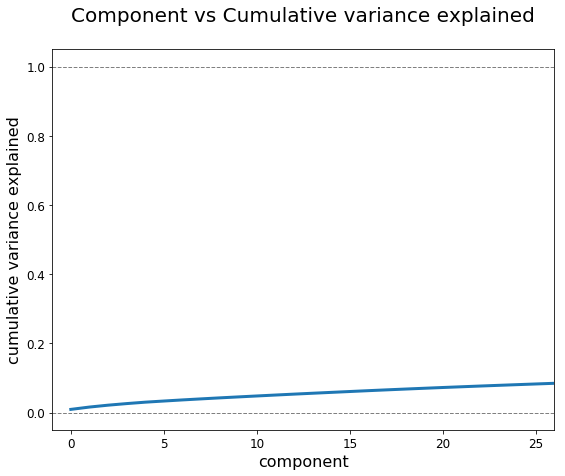

In [697]:
plt.figure(figsize=(9,7))

# Plot the cumulative explained variance
component_number = range(len(cum_var_exp))
plt.plot(component_number, cum_var_exp, lw=3)

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([-1,26])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('Component vs Cumulative variance explained\n', fontsize=20)

plt.show()

If we wanted to explain the most variability in our data with principal components, we would need to keep all the number of principal components and even then it would not explain much. Nevertheless, this is a display of the comparison between the original performance and our PCA's performance. Evidently, the PCA performance does not improve our original performance. As a result, we will forgo this model and try out another.

In [698]:
# Instantiate linear regression model.
logreg = LogisticRegression()

# Fit on X_train.
logreg.fit(X_train_tfidf, y_train)

# Score on training and testing sets.
print(f'Training Score: {round(logreg.score((X_train_tfidf), y_train),4)}.')
print(f'Testing Score: {round(logreg.score((X_test_tfidf), y_test),4)}.')

/Users/jameslee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Score: 0.9592.
Testing Score: 0.9513.


In [710]:
# Instantiate linear regression model.
logreg = LogisticRegression()

# Transform Z_train and Z_test.
Z_train = pca.fit_transform(X_train_array)
Z_test = pca.transform(X_test_array)

# Fit on Z_train.
logreg.fit(Z_train, y_train)

# Score on training and testing sets.
print(f'Training Score: {round(logreg.score((Z_train), y_train),4)}.')
print(f'Testing Score: {round(logreg.score((Z_test), y_test),4)}.')

/Users/jameslee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Score: 0.8648.
Testing Score: 0.865.
